# D Parameter Sweep Analysis

analyze how projection dimension d affects model performance and stability


In [1]:
import sys
sys.path.append('..')

import numpy as np
import torch
import matplotlib.pyplot as plt
from src.experiments import run_sweep_d_agg, repeat_spherical_runs_for_d
from src.training import run_exact
from src.config import TrainCfg
from src.kernels import SM_kernel, stable_matern_kernel, stable_rbf_kernel, long_periodic_plus_short_rbf
from src.utils import plot_posteriors_auto


## Generate Toy Data


In [2]:
# generate toy data
torch.manual_seed(0)
np.random.seed(0)
N = 1000
x = 100 * np.random.rand(N) + 0.1 * np.random.randn(N)
y = 20 * np.cos(1.5 * x) * np.cos(0.1 * x) + 0.1 * np.random.randn(N)
x_plot = np.linspace(0, 100, 200)

n_train = int(0.7*N)

x_train = torch.tensor(x[:n_train], dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_test = torch.tensor(x[n_train:], dtype=torch.float32).unsqueeze(-1)
y_test = torch.tensor(y[n_train:], dtype=torch.float32)

print(f"train: {len(x_train)}, test: {len(x_test)}")


train: 700, test: 300


## Run Exact GP Baseline


In [3]:
# train once for baseline lines
res_exact = run_exact(
    x_train, y_train, x_test, y_test,
    kernel=SM_kernel(1, 1, y_std=float(torch.std(y_train))),
    cfg=TrainCfg(verbose=False),
    init_from_data=False
)

print(f"exact GP baseline - RMSE: {res_exact['metrics']['RMSE']:.4f}, R2: {res_exact['metrics']['R2']:.4f}")


exact GP baseline - RMSE: 0.0982, R2: 0.9999


## Sweep Over D Values


  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [02:38<00:00, 19.84s/it]


     RMSE_mean  RMSE_std   R2_mean    R2_std   NLPD_mean    NLPD_std  \
d                                                                      
10    6.697012  5.701526  0.290495  0.660501  188.934521  191.020812   
20    1.023826  2.687826  0.927653  0.227627    1.349597    3.516450   
50    2.045852  3.440192  0.858290  0.374157   22.518303   68.941913   
100   0.290693  0.187748  0.998885  0.001478    0.400909    0.173287   
200   0.824347  1.038934  0.984194  0.029879    0.668395    0.518992   
300   0.267166  0.153524  0.999112  0.000917    0.500585    0.184372   
400   0.485779  0.852044  0.991491  0.024952    0.572621    0.412404   
500   0.352299  0.321244  0.997919  0.003801    0.551224    0.248442   

     time_sec_mean  time_sec_std  
d                                 
10        1.103704      0.621232  
20        1.935839      0.867543  
50        1.878906      1.129418  
100       1.580848      0.717236  
200       1.592407      0.888019  
300       2.148674      1.402912  

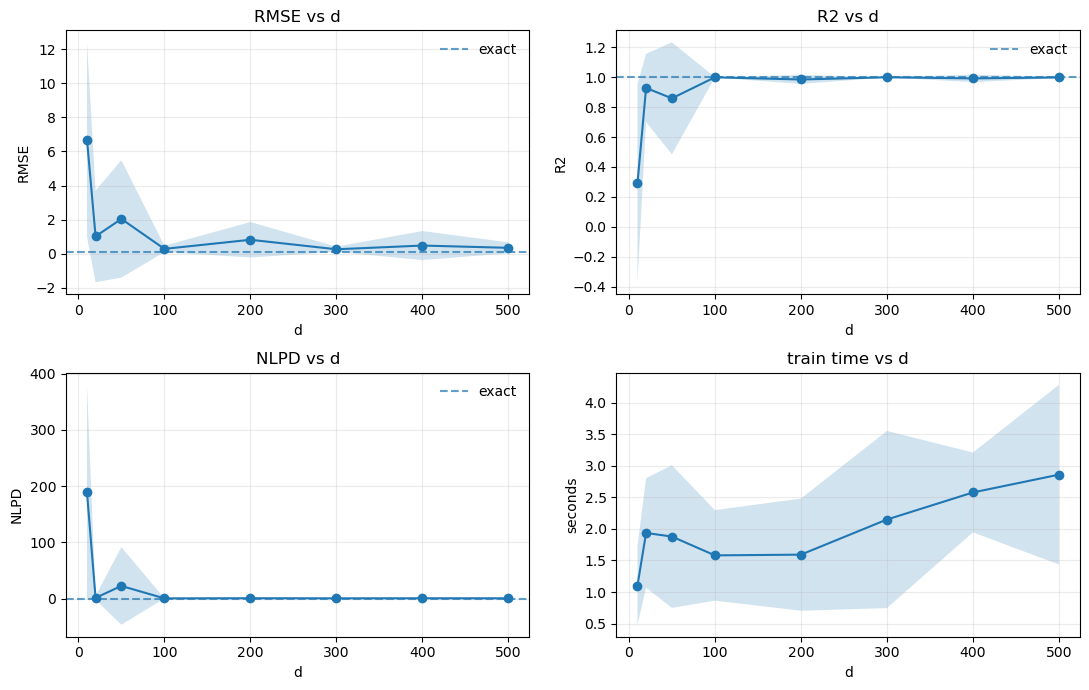

[sweep-d agg] best d by RMSE_mean: 300 (RMSE=0.2672+/-0.1535, R2=0.9991+/-0.0009, NLPD=0.5006+/-0.1844, time=2.15+/-1.40s)


In [5]:
# sweep and aggregate
d_list = [10, 20, 50, 100, 200, 300, 400, 500]
df_agg, reps_for_best, runs_raw = run_sweep_d_agg(
    x_train, y_train, x_test, y_test,
    d_list=d_list,
    n_repeats=10,
    num_mixtures=1,
    cfg=TrainCfg(max_iter=500, patience=40, lr=0.05, verbose=False),
    init_hyps_data=False,
    res_exact=res_exact,
    res_svgp=None,
    savepath='../results/d_sweep_metrics.png',
    xscale_log=False
)


## Visualise Best D


best d: 300


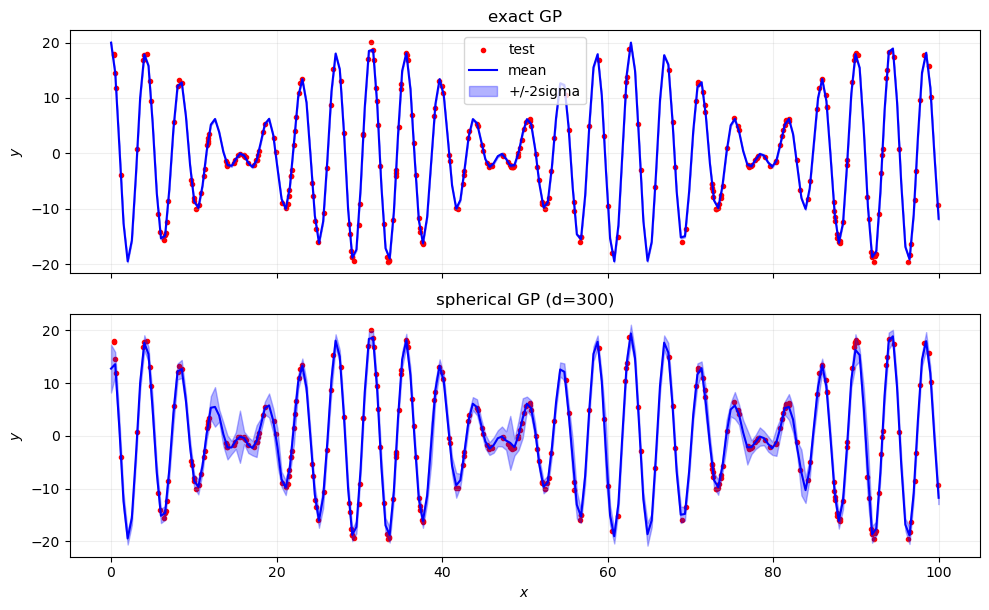

In [6]:
# visualise posterior for the best d using one representative run
best_d = int(df_agg['RMSE_mean'].idxmin())
print(f"best d: {best_d}")

from src.training import predict_svgp

_ = plot_posteriors_auto(
    D=x_train.shape[1],
    res_exact=res_exact,
    res_proj=reps_for_best[best_d],  # first repeat at best d
    res_svgp=None,
    x_test=x_test, y_test=y_test, x_plot=x_plot,
    d_proj=best_d,
    predict_svgp_fn=predict_svgp,
    plot1d_fn=None,
    add_svgp_heatmap=False,
    savepath=None
)


## Hyperparameter Variability Analysis


100%|██████████| 30/30 [01:02<00:00,  2.07s/it]


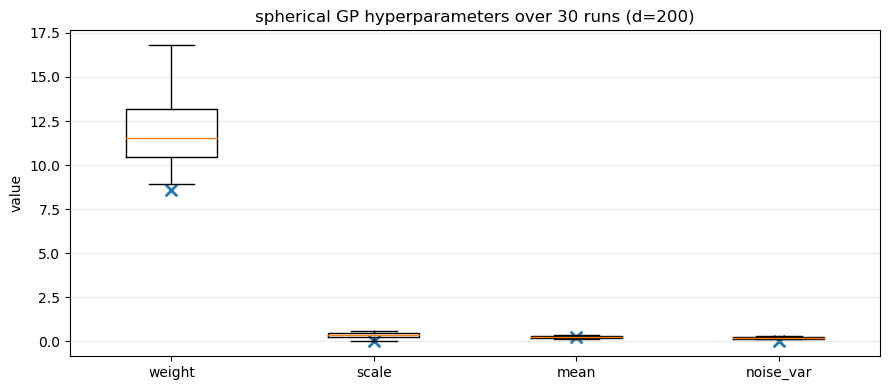

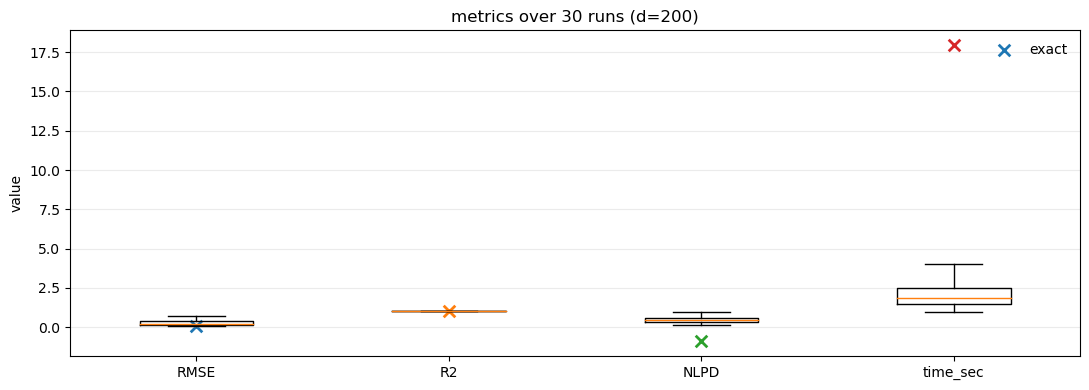

In [7]:
# analyse hyperparameter stability for a fixed d
df_hyp, df_metric, reps = repeat_spherical_runs_for_d(
    x_train, y_train, x_test, y_test,
    d=200,
    k=30,
    num_mixtures=1,
    cfg=TrainCfg(max_iter=500, patience=40, lr=0.05, verbose=False),
    init_hyps_data=False,
    res_exact=res_exact,
    savepath_hyp='../results/hyp_box_d200.png',
    savepath_nlpd='../results/nlpd_box_d200.png'
)
